In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
import re
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
df = pd.read_csv("/home/tural/Desktop/datas/Corona_NLP_train.csv",engine="python")
df_t = pd.read_csv("/home/tural/Desktop/datas/Corona_NLP_test.csv",engine="python")

In [3]:
df.Location = df.Location.fillna('unknown')
df_t.Location = df_t.Location.fillna('unknown')

<AxesSubplot:xlabel='count', ylabel='Location'>

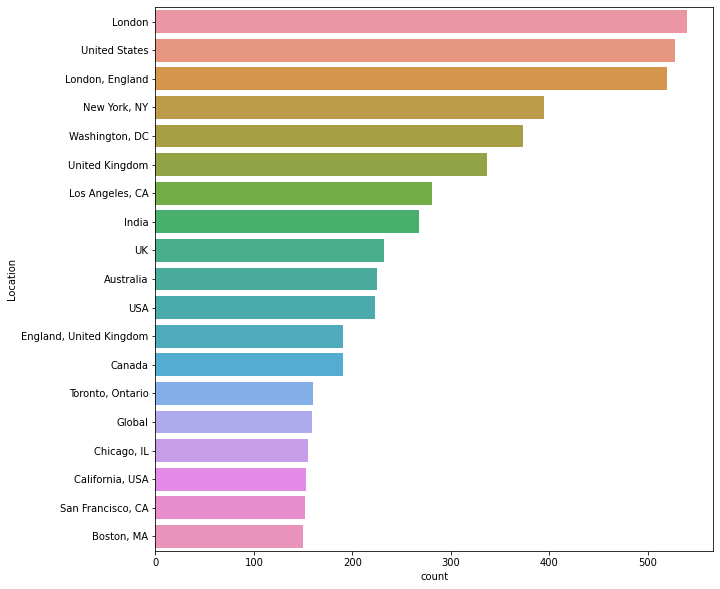

In [4]:
plt.figure(figsize=(10,10))
sns.countplot(y='Location',data=df,order=df.Location.value_counts().iloc[1:20].index)

In [5]:
stop_words = stopwords.words('english')

In [6]:
def clean_data(twit):
    # Remove URLS
    twit = re.sub(r'http\S+', ' ', twit)
    
    #remove html
    
    twit = re.sub(r'<.*?>', " ",twit)
    
    #Removeing digits
    
    twit = re.sub(r'\d+',' ', twit)
    
    #remove hastags
    
    twit = re.sub(r'#\w+',' ', twit)
    
    #remove mentioned
    
    twit = re.sub(r'@\w+',' ', twit)
    
    #remove money
    
    twit = re.sub(r'£|\$', 'money', twit)
   
    #remove stop words
    
    twit = twit.split()
    twit = " ".join([word for word in twit if not word in stop_words])
    
    
    return twit

In [7]:
df["text"] = df["OriginalTweet"].apply(clean_data)
df_t["text"] = df_t["OriginalTweet"].apply(clean_data)

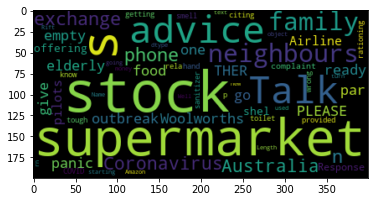

In [8]:
ws = WordCloud()
ws.generate(str(df["text"]))
plt.imshow(ws, interpolation='bilinear')

In [9]:
df['target'] = df['Sentiment']
df['target'].replace({'Neutral':0,'Extremely Negative':1,'Negative':1,'Positive':2,'Extremely Positive':2},inplace=True)
df_t['target'] = df_t['Sentiment']
df_t['target'].replace({'Neutral':0,'Extremely Negative':1,'Negative':1,'Positive':2,'Extremely Positive':2},inplace=True)


In [10]:
X_train = df['text']
y_train = df['target']
X_test = df_t['text']
y_test = df_t['target']

In [11]:
max_len = np.max(X_train.apply(lambda x :len(x)))
print(max_len)

296


In [12]:
tokenizer = Tokenizer()

In [13]:
tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')


In [14]:
print(vocab_length)

35860


In [15]:
y_train.unique()

array([0, 2, 1])

In [17]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
embading_dim = 16

In [19]:
import pickle

pickle_out = open("y_train.pickle",'wb')
pickle.dump(y_train,pickle_out)
pickle_out.close()

pickle_out = open("y_test.pickle",'wb')
pickle.dump(y_test,pickle_out)
pickle_out.close()

pickle_out = open("X_train.pickle",'wb')
pickle.dump(X_train,pickle_out)
pickle_out.close()

pickle_out = open("X_test.pickle",'wb')
pickle.dump(X_test,pickle_out)
pickle_out.close()

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embading_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')     
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 296, 16)           573760    
_________________________________________________________________
bidirectional (Bidirectional (None, 296, 128)          41472     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 623,683
Trainable params: 623,683
Non-trainable params: 0
__________________________________________________

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
history = model.fit(X_train,y_train,epochs=10,batch_size=64, validation_data=(X_test,y_test))

Epoch 1/10
644/644 [==============================] - 224s 341ms/step - loss: 1.0387 - accuracy: 0.4385 - val_loss: 0.7960 - val_accuracy: 0.6445
Epoch 2/10
644/644 [==============================] - 220s 342ms/step - loss: 0.6855 - accuracy: 0.7218 - val_loss: 0.5048 - val_accuracy: 0.8183
Epoch 3/10
644/644 [==============================] - 251s 390ms/step - loss: 0.3627 - accuracy: 0.8849 - val_loss: 0.4431 - val_accuracy: 0.8502
Epoch 4/10
644/644 [==============================] - 230s 357ms/step - loss: 0.2560 - accuracy: 0.9257 - val_loss: 0.4726 - val_accuracy: 0.8476
Epoch 5/10
644/644 [==============================] - 185s 288ms/step - loss: 0.1910 - accuracy: 0.9444 - val_loss: 0.7179 - val_accuracy: 0.7330
Epoch 6/10
644/644 [==============================] - 186s 288ms/step - loss: 0.2635 - accuracy: 0.9182 - val_loss: 0.5681 - val_accuracy: 0.8320
Epoch 7/10
644/644 [==============================] - 199s 309ms/step - loss: 0.1695 - accuracy: 0.9472 - val_loss: 0.6520 -

In [25]:
yp = model.predict(X_test)

In [26]:
pred = model.predict_classes(X_test)

/home/tural/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
print(classification_report(np.argmax(y_test,1),pred))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74       619
           1       0.85      0.79      0.82      1633
           2       0.83      0.86      0.84      1546

    accuracy                           0.82      3798
   macro avg       0.80      0.81      0.80      3798
weighted avg       0.82      0.82      0.82      3798



In [30]:
cm = tf.math.confusion_matrix(labels=np.argmax(y_test,1),predictions=pred)

Text(69.0, 0.5, 'Truth')

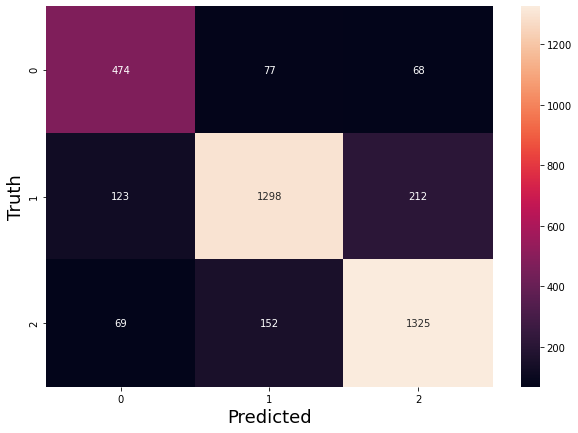

In [37]:
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted',fontsize=18)
plt.ylabel('Truth',fontsize=18)